<a href="https://colab.research.google.com/github/serjisa/transcriptomics.msu/blob/main/%D0%A1%D0%B5%D0%BC%D0%B8%D0%BD%D0%B0%D1%80%D1%8B/11_%D0%92%D0%B0%D1%80%D0%B8%D0%B0%D1%86%D0%B8%D0%BE%D0%BD%D0%BD%D1%8B%D0%B5_%D0%B0%D0%B2%D1%82%D0%BE%D1%8D%D0%BD%D0%BA%D0%BE%D0%B4%D0%B5%D1%80%D1%8B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Семинар 11. Автоэнкодеры на PyTorch. Препарирование scVI

В этом семинаре мы разберемся в реализации автоэнкодеров на PyTorch, а также с моделями scvi-tools для scRNA-seq.

Для обучения моделей мы будем использовать GPU. Для этого в верхнем меню выберем `Runtime` -> `Change runtime type` -> `GPU`.

Установим и импортируем все необходимые библиотеки

In [ ]:
!pip install torch torchvision
!pip install scanpy

!pip install --quiet scvi-colab
from scvi_colab import install
install()

import os
os.kill(os.getpid(), 9)

In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt

## Немного про PyTorch

PyTorch - основная из двух главных библиотек для глубокого обучения на питоне (наряду с TensorFlow).



### Тензоры

Основной тип объектов в PyTorch - тензор. По сути тензор аналогичен NumPy массиву, но позволяет использовать GPU для работы с ним

In [ ]:
torch.tensor([[1,2,3],[4,5,6],[7,8,9]])

tensor([[1, 2, 3],
        [4, 5, 6],
        [7, 8, 9]])

In [ ]:
torch.ones(3,3)

tensor([[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]])

In [ ]:
my_array = np.array([[1,2,3],[4,5,6],[7,8,9]])

my_tensor = torch.from_numpy(my_array)
my_tensor

tensor([[1, 2, 3],
        [4, 5, 6],
        [7, 8, 9]])

In [ ]:
my_tensor.numpy()

array([[1, 2, 3],
       [4, 5, 6],
       [7, 8, 9]])

Тензоры имеют те же аттрибуты, что и NumPy массивы

In [ ]:
my_tensor.shape

torch.Size([3, 3])

In [ ]:
my_tensor.dtype

torch.int64

А также дополнительный аттрибут `device` с информацией о том, где хранится тензор

In [ ]:
my_tensor.device

device(type='cpu')

### PyTorch device

По умолчанию тензоры хранятся на CPU, но мы можем переместить их на GPU

(CUDA - Compute Unified Device Architecture, платформа Nvidia)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
my_tensor.to(device)

tensor([[1, 2, 3],
        [4, 5, 6],
        [7, 8, 9]], device='cuda:0')

### Datasets, DataLoaders

Загрузим датасет MNIST

`torch.utils.data.Dataset` позволяет хранить данные, а `torch.utils.data.DataLoader` создает итератор для эффективной работы с ними

In [ ]:
train_dataset = torchvision.datasets.MNIST(root="./data", train=True, transform=torchvision.transforms.ToTensor(), download=True)

test_dataset = torchvision.datasets.MNIST(root="./data", train=False, transform=torchvision.transforms.ToTensor(), download=True)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



### Нейросети

Создадим простейшую нейросеть, наследующую классу `nn.Module`

In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [ ]:
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [ ]:
#создаем случайные данные и пропускаем их через нейросеть
X = torch.rand(1, 28, 28, device=device)
logits = model(X)

#превращаем действительные числа, выданные нейросетью, в вероятности
pred_probab = nn.Softmax(dim=1)(logits)

#получаем "предсказание класса" - класс с наибольшей вероятностью принадлежности к нему
y_pred = pred_probab.argmax(1)
print(f"Predicted class: {y_pred}")

Predicted class: tensor([1], device='cuda:0')


### Обучение модели

In [ ]:
learning_rate = 1e-3
batch_size = 64
epochs = 5

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [ ]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        X = X.to(device)
        y = y.to(device)

        # Получаем предсказание и лосс
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [ ]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_loader, model, loss_fn, optimizer)
    test_loop(test_loader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.306562  [    0/60000]
loss: 2.300678  [12800/60000]
loss: 2.296772  [25600/60000]
loss: 2.290774  [38400/60000]
loss: 2.283223  [51200/60000]
Test Error: 
 Accuracy: 23.0%, Avg loss: 2.280092 

Epoch 2
-------------------------------
loss: 2.285160  [    0/60000]
loss: 2.277742  [12800/60000]
loss: 2.266461  [25600/60000]
loss: 2.261595  [38400/60000]
loss: 2.258673  [51200/60000]
Test Error: 
 Accuracy: 47.6%, Avg loss: 2.255583 

Epoch 3
-------------------------------
loss: 2.254072  [    0/60000]
loss: 2.244982  [12800/60000]
loss: 2.248099  [25600/60000]
loss: 2.240286  [38400/60000]
loss: 2.228395  [51200/60000]
Test Error: 
 Accuracy: 60.7%, Avg loss: 2.226368 

Epoch 4
-------------------------------
loss: 2.237166  [    0/60000]
loss: 2.218137  [12800/60000]
loss: 2.217519  [25600/60000]
loss: 2.207820  [38400/60000]
loss: 2.196959  [51200/60000]
Test Error: 
 Accuracy: 66.1%, Avg loss: 2.189273 

Epoch 5
------------------------

## Простейший аутоэнкодер на PyTorch

Чтобы познакомиться (или же освежить в памяти) создание моделей и нейросетей на PyTorch, реализуем для начала простейший, не вариационный автоэнкодер и применим ему к датасету MNIST с рукописными записями цифр

В этой части семинара мы будем пользоваться кодом из https://afagarap.github.io/2020/01/26/implementing-autoencoder-in-pytorch.html

Создадим нашу модель, наследующую классу `torch.nn.Module`

In [ ]:
class AE(nn.Module):
  def __init__(self, **kwargs):
    super().__init__()
    self.encoder = nn.Sequential(
        nn.Linear(in_features=kwargs["input_shape"], out_features=128),
        nn.ReLU(),
        nn.Linear(in_features=128, out_features=128),
        nn.ReLU()
    )
    self.decoder = nn.Sequential(
        nn.Linear(in_features=128, out_features=128),
        nn.ReLU(),
        nn.Linear(in_features=128, out_features=kwargs["input_shape"]),
        nn.ReLU()
    )

  def forward(self, features):
    code = self.encoder(features)
    reconstructed = self.decoder(code)
    return reconstructed

Зададим оптимизацию и loss function


In [ ]:
model = AE(input_shape=784).to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-3)

criterion = nn.MSELoss()

Теперь давайте обучим нашу модель!

In [ ]:
epochs = 10
for epoch in range(epochs):
  loss = 0
  for batch_features, _ in train_loader:
    # reshape mini-batch data to [N, 784] matrix
    # load it to the active device
    batch_features = batch_features.view(-1, 784).to(device)
    
    # reset the gradients back to zero
    # PyTorch accumulates gradients on subsequent backward passes
    optimizer.zero_grad()
    
    # compute reconstructions
    outputs = model(batch_features)
    
    # compute training reconstruction loss
    train_loss = criterion(outputs, batch_features)
    
    # compute accumulated gradients
    train_loss.backward()
    
    # perform parameter update based on current gradients
    optimizer.step()
    
    # add the mini-batch training loss to epoch loss
    loss += train_loss.item()
  
  # compute the epoch training loss
  loss = loss / len(train_loader)
  
  # display the epoch training loss
  print("epoch : {}/{}, loss = {:.6f}".format(epoch + 1, epochs, loss))

epoch : 1/10, loss = 0.031873
epoch : 2/10, loss = 0.017194
epoch : 3/10, loss = 0.015260
epoch : 4/10, loss = 0.014262
epoch : 5/10, loss = 0.013600
epoch : 6/10, loss = 0.013125
epoch : 7/10, loss = 0.012775
epoch : 8/10, loss = 0.012493
epoch : 9/10, loss = 0.012266
epoch : 10/10, loss = 0.012090


Получим предсказания нашей модели на объектах из тестовой выборки

In [ ]:
test_examples = None

with torch.no_grad():
  for batch_features in test_loader:
    batch_features = batch_features[0]
    test_examples = batch_features.view(-1, 784).to(device)
    reconstruction = model(test_examples)
    break

Отрисуем предсказания автоэнкодера для десяти из этих объектов, а также сами оригинальные объекты

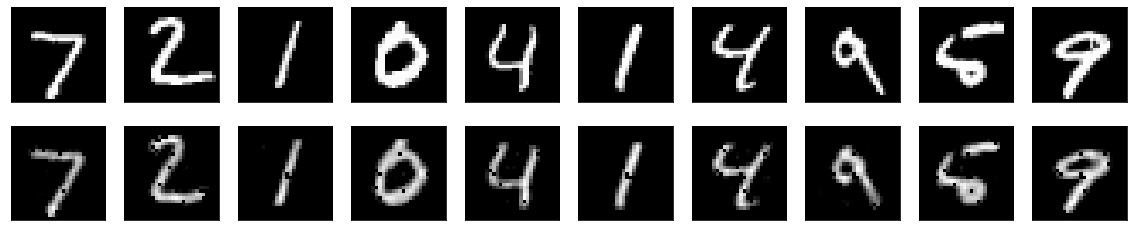

In [ ]:
with torch.no_grad():
  number = 10
  plt.figure(figsize=(20, 4))
  for index in range(number):
    # display original
    ax = plt.subplot(2, number, index + 1)
    plt.imshow(test_examples[index].cpu().numpy().reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, number, index + 1 + number)
    plt.imshow(reconstruction[index].cpu().numpy().reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
  plt.show()

## Архитектура scVI

Создадим класс для нейросетей, которые будем использовать в качестве энкодеров и декодеров

In [ ]:
from scvi._compat import Literal

class MyNeuralNet(torch.nn.Module):
    def __init__(
        self,
        n_input: int,
        n_output: int,
        link_var: Literal["exp", "none", "softmax"],
    ):
        super().__init__()
        self.neural_net = torch.nn.Sequential(
            torch.nn.Linear(n_input, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, n_output),
        )
        self.transformation = None
        if link_var == "softmax":
            self.transformation = torch.nn.Softmax(dim=-1)
        elif link_var == "exp":
            self.transformation = torch.exp

    def forward(self, x: torch.Tensor):
        output = self.neural_net(x)
        if self.transformation:
            output = self.transformation(output)
        return output

INFO:pytorch_lightning.utilities.seed:Global seed set to 0
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/warnings.py:54: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  "pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6"
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)


Попробуем создать сеть с помощью этого класса и посмотрим на ее архитектуру:

In [ ]:
my_neural_net = MyNeuralNet(100, 10, "softmax")
my_neural_net

MyNeuralNet(
  (neural_net): Sequential(
    (0): Linear(in_features=100, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=10, bias=True)
  )
  (transformation): Softmax(dim=-1)
)

Теперь создадим вариационный автоэнкодер, соответствующий упрощенной модели scVI:

In [ ]:
from torch.distributions import NegativeBinomial, Normal
from torch.distributions import kl_divergence as kl

from scvi import REGISTRY_KEYS 
from scvi.module.base import (
    BaseModuleClass,
    LossRecorder,
    auto_move_data,
)

class MyModule(BaseModuleClass):
    def __init__(
        self,
        n_input: int,
        n_latent: int = 10,
    ):
        super().__init__()
        
        self.decoder = MyNeuralNet(n_latent, n_input, "softmax")
        self.log_theta = torch.nn.Parameter(torch.randn(n_input))

        self.mean_encoder = MyNeuralNet(n_input, n_latent, "none")
        self.var_encoder = MyNeuralNet(n_input, n_latent, "exp")

    @auto_move_data
    def inference(self, x):
        # логарифмируем входные данные
        x_ = torch.log(1 + x)
        # с помощью энкодеров получим значение для среднего и дисперсии латентого распределения
        qz_m = self.mean_encoder(x_)
        qz_v = self.var_encoder(x_)
        # сэмплируем распределение латентных переменных 
        z = Normal(qz_m, torch.sqrt(qz_v)).rsample()

        outputs = dict(qz_m=qz_m, qz_v=qz_v, z=z)
        return outputs

    @auto_move_data
    def generative(self, z, library):
        # используем декодер для среднего отрицательного биномиального распределения
        px_scale = self.decoder(z)
        # умножим его на размер библиотеки
        px_rate = library * px_scale
        # сгенерируем дисперсию отрицательного биномиального распределения
        theta = torch.exp(self.log_theta)

        return dict(
            px_scale=px_scale, theta=theta, px_rate=px_rate
        )

    def loss(
        self,
        tensors,
        inference_outputs,
        generative_outputs,
    ):

        # получаем наши оценки для параметров
        x = tensors[REGISTRY_KEYS.X_KEY]
        px_rate = generative_outputs["px_rate"]
        theta = generative_outputs["theta"]
        qz_m = inference_outputs["qz_m"]
        qz_v = inference_outputs["qz_v"]

        # переводим выходные данные декодера в параметры отрицательного биномиального распределение
        nb_logits = (px_rate + 1e-4).log() - (theta + 1e-4).log()
        # подсчитываем лог правдоподобие
        log_lik = NegativeBinomial(total_count=theta, logits=nb_logits).log_prob(x).sum(dim=-1)    

        # подсчитываем KL-дивергенцию нашего распределения латентных переменных и стандартного нормального распределения
        prior_dist = Normal(torch.zeros_like(qz_m), torch.ones_like(qz_v))
        var_post_dist = Normal(qz_m, torch.sqrt(qz_v))
        kl_divergence = kl(var_post_dist, prior_dist).sum(dim=1)

        #вычисляем ELBO и создаем лосс на его основе
        elbo = log_lik - kl_divergence
        loss = torch.mean(-elbo)
        return LossRecorder(loss, -log_lik, kl_divergence, 0.0)


Теперь посмотрим на вариационный автоэнкодер, в действительности используемый базовой моделью scvi-tools - scVI: https://github.com/scverse/scvi-tools/blob/9e13c6e6d2b12de3afe5f9ec5bb4b69e19b4be64/scvi/module/_vae.py#L22.

## Работа с scVI

### Снижение размерности и коррекция батч-эффекта

Теперь давайте посмотрим, как выглядит работа с scVI с точки зрения обычного пользователя

In [ ]:
import scvi
import scanpy as sc

sc.set_figure_params(figsize=(5, 5))

Загрузим датасет и препроцессируем его стандартными методами из scanpy

In [ ]:
# Загрузим датасет
!wget -O PBMC_Satija.h5ad --no-check-certificate "https://docs.google.com/uc?export=download&id=1jW548g6ERFS0t7NywgyjRs6VaE5QwXbg&confirm=t"

--2022-11-25 15:24:30--  https://docs.google.com/uc?export=download&id=1jW548g6ERFS0t7NywgyjRs6VaE5QwXbg&confirm=t
Resolving docs.google.com (docs.google.com)... 172.253.118.139, 172.253.118.102, 172.253.118.113, ...
Connecting to docs.google.com (docs.google.com)|172.253.118.139|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-04-6s-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/7hiln7ajvu0bflkasjn759pqtpam66vc/1669389825000/08626740090461398144/*/1jW548g6ERFS0t7NywgyjRs6VaE5QwXbg?e=download&uuid=880fdcb6-ecb9-400e-aaf4-2fb76a129d81 [following]
--2022-11-25 15:24:30--  https://doc-04-6s-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/7hiln7ajvu0bflkasjn759pqtpam66vc/1669389825000/08626740090461398144/*/1jW548g6ERFS0t7NywgyjRs6VaE5QwXbg?e=download&uuid=880fdcb6-ecb9-400e-aaf4-2fb76a129d81
Resolving doc-04-6s-docs.googleusercontent.com (doc-04-6s-docs.googleusercontent.com)... 172.217.194.

In [ ]:
adata = sc.read_h5ad("PBMC_Satija.h5ad")
adata.layers["counts"] = adata.X.copy()

In [ ]:
sc.pp.filter_genes(adata, min_counts=3)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=1200,
    subset=True,
    layer="counts",
    flavor="seurat_v3",
    batch_key="donor"
)

Созадим модель scVI

In [ ]:
scvi.model.SCVI.setup_anndata(
    adata,
    layer="counts",
    batch_key="donor"
)
model = scvi.model.SCVI(adata)
model

SCVI Model with the following params: 
n_hidden: 128, n_latent: 10, n_layers: 1, dropout_rate: 0.1, dispersion: gene, gene_likelihood: zinb, 
latent_distribution: normal
Training status: Not Trained

Обучим её

In [ ]:
model.train(max_epochs=100)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 100/100: 100%|██████████| 100/100 [02:27<00:00,  1.43s/it, loss=407, v_num=1]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 100/100: 100%|██████████| 100/100 [02:27<00:00,  1.47s/it, loss=407, v_num=1]


Выгрузим полученное латентное представление

In [ ]:
latent = model.get_latent_representation()
adata.obsm["X_scVI"] = latent

Посмотрим, как выглядит UMAP нашего датасета без батч-коррекции

In [ ]:
sc.tl.pca(adata)
sc.pp.neighbors(adata, n_pcs=30, n_neighbors=20)
sc.tl.leiden(adata)
sc.tl.umap(adata)

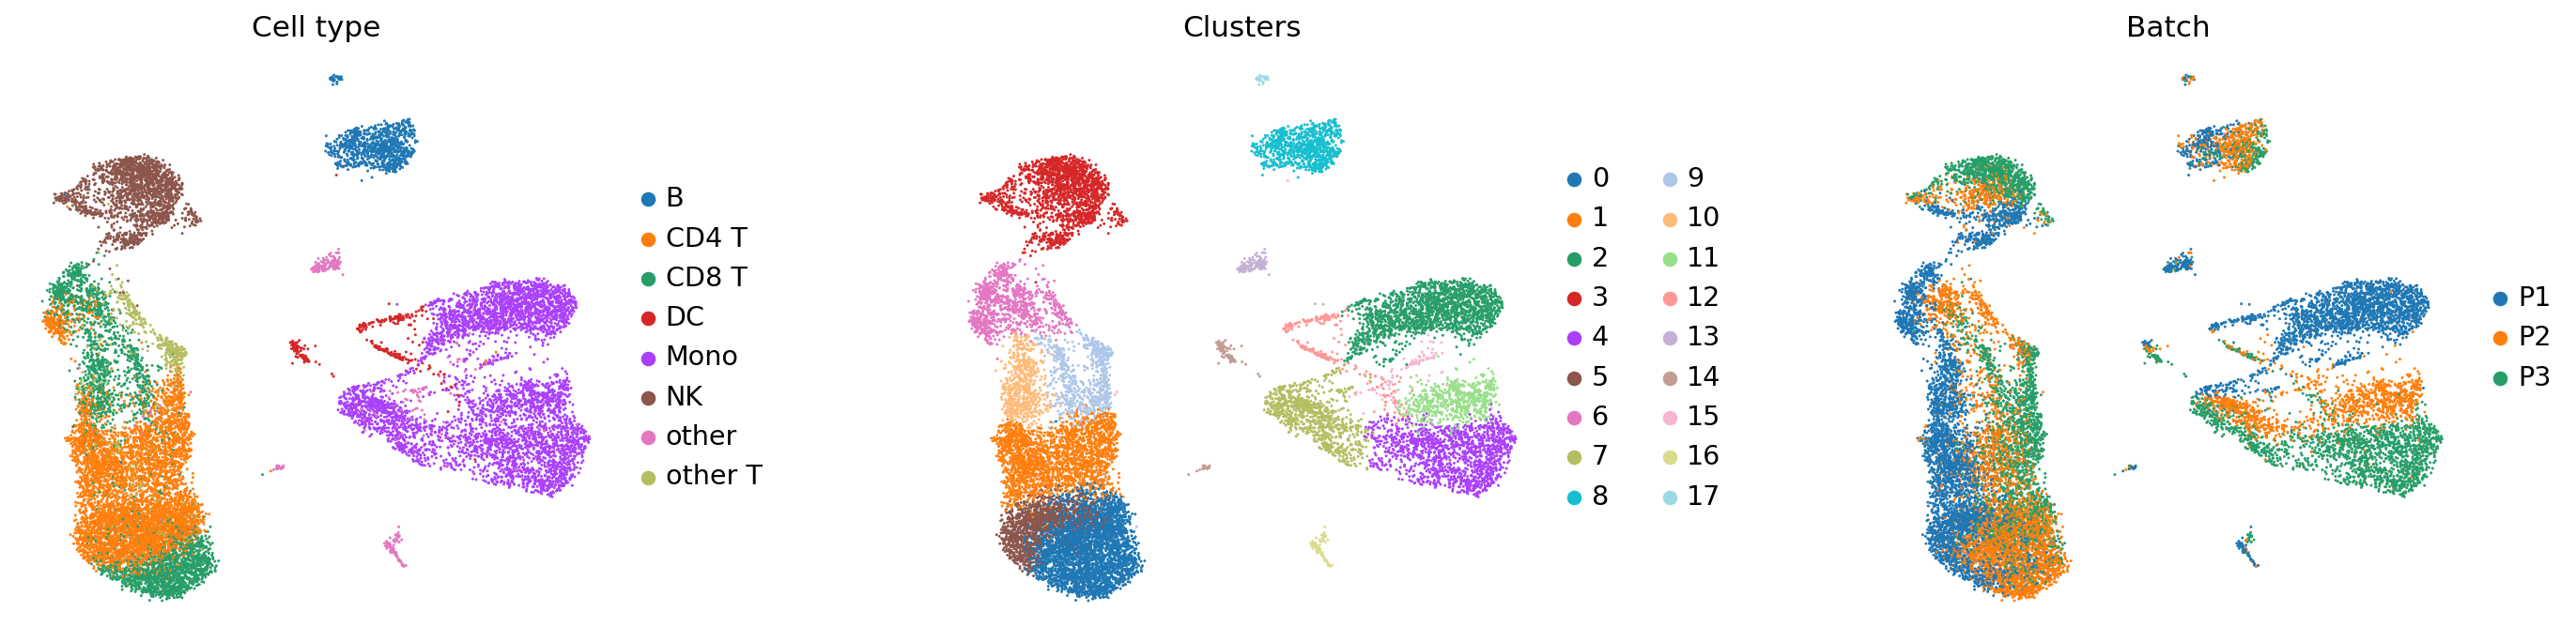

In [ ]:
sc.pl.umap(adata, color=["celltype.l1", "leiden", "donor"],
           title=["Cell type", "Clusters", "Batch"], wspace=0.4, frameon=False)

Теперь построим UMAP не на PCA, а на выученном scVI латентном представлении

In [ ]:
sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.leiden(adata, key_added="leiden_scVI", resolution=0.5)
sc.tl.umap(adata)

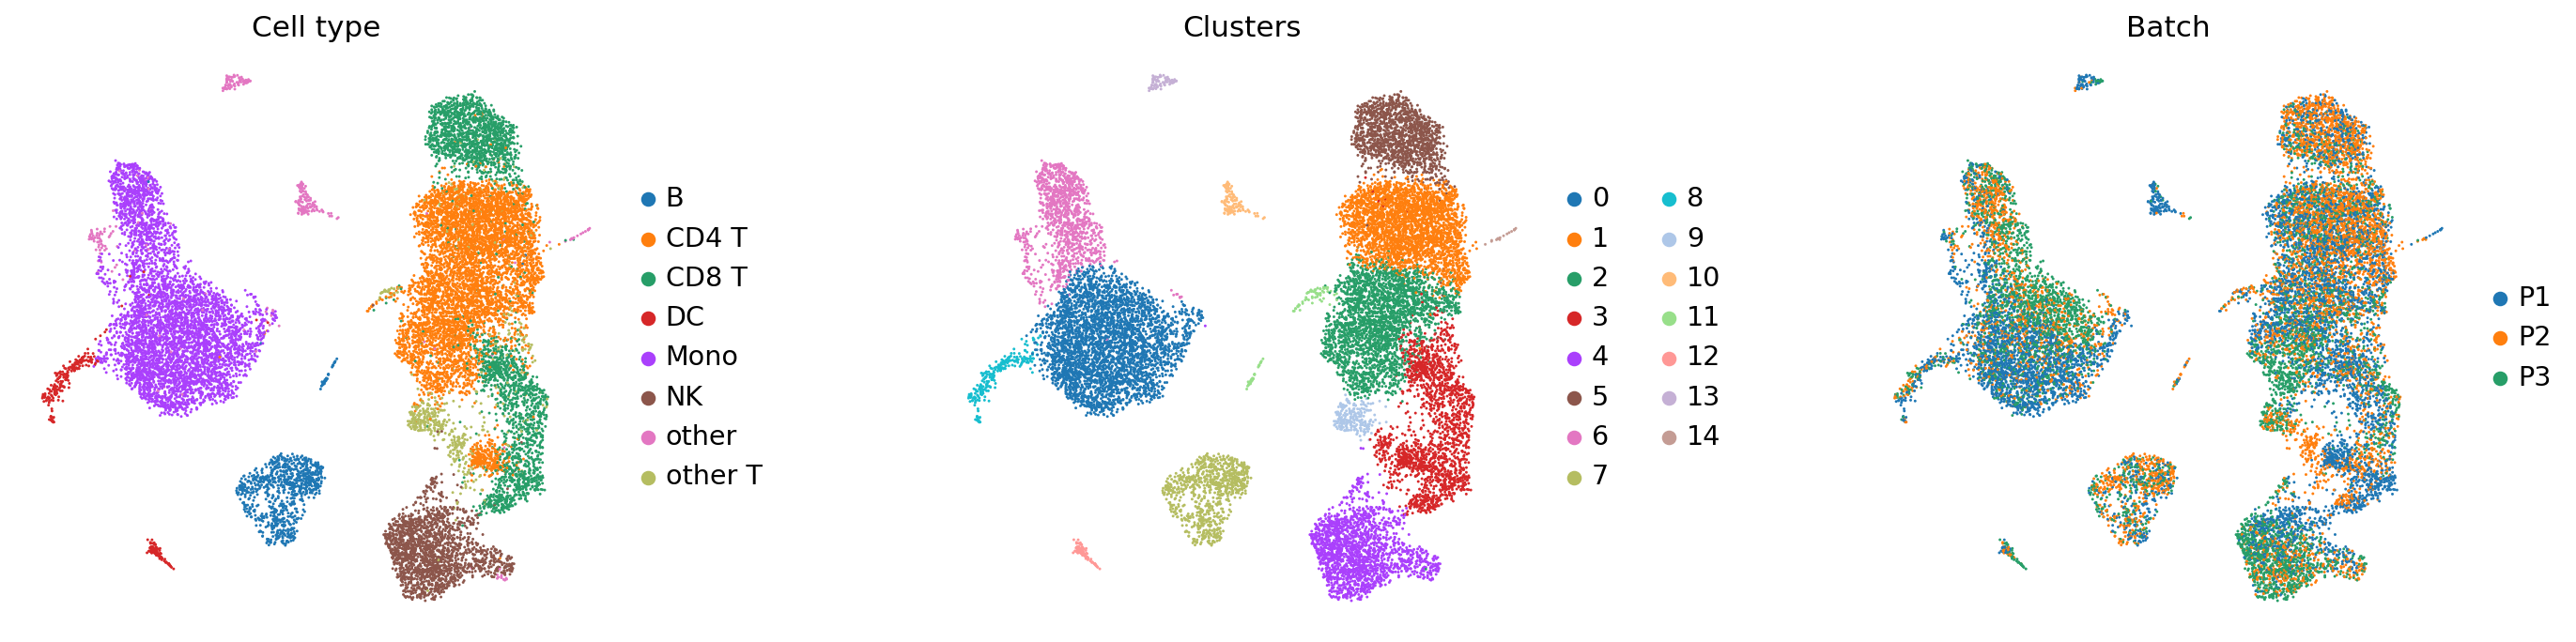

In [ ]:
sc.pl.umap(adata, color=["celltype.l1", "leiden_scVI", "donor"],
           title=["Cell type", "Clusters", "Batch"], wspace=0.4, frameon=False)

### Дифференциальная экспрессия с помощью scVI

Сравним NK- и B-клетки

In [ ]:
de_df = model.differential_expression(
    groupby="celltype.l1",
    group1="NK",
    group2="B"
)
de_df.head()

DE...: 100%|██████████| 1/1 [00:02<00:00,  2.17s/it]


,proba_de,proba_not_de,bayes_factor,scale1,scale2,pseudocounts,delta,lfc_mean,lfc_median,lfc_std,...,raw_mean1,raw_mean2,non_zeros_proportion1,non_zeros_proportion2,raw_normalized_mean1,raw_normalized_mean2,is_de_fdr_0.05,comparison,group1,group2
LINC01781,1.0,0.0,18.420681,0.000012,0.000789,0.0,0.25,-5.948374,-5.886632,1.642155,...,0.001118,0.405078,0.001118,0.186534,0.008042,4.010772,True,NK vs B,NK,B
IGLC3,1.0,0.0,18.420681,0.000080,0.010203,0.0,0.25,-6.654182,-6.625886,1.610484,...,0.032979,15.328912,0.030184,0.402870,0.298464,82.117180,True,NK vs B,NK,B
IGKC,1.0,0.0,18.420681,0.000410,0.034120,0.0,0.25,-6.155337,-6.121027,1.041603,...,0.415316,88.182121,0.269424,0.822296,3.917510,477.377869,True,NK vs B,NK,B
NKG7,1.0,0.0,18.420681,0.030621,0.000479,0.0,0.25,6.747175,6.797639,1.320463,...,34.278885,0.275938,0.999441,0.087196,313.666718,2.343776,True,NK vs B,NK,B
KIR2DL1,1.0,0.0,18.420681,0.000284,0.000002,0.0,0.25,7.226782,7.212592,1.573433,...,0.166015,0.000000,0.116266,0.000000,1.513902,0.000000,True,NK vs B,NK,B


Сравним все типы клеток друг с другом

In [ ]:
de_df = model.differential_expression(
    groupby="celltype.l1"
)
de_df.head()

DE...: 100%|██████████| 8/8 [00:06<00:00,  1.17it/s]


,proba_de,proba_not_de,bayes_factor,scale1,scale2,pseudocounts,delta,lfc_mean,lfc_median,lfc_std,...,raw_mean1,raw_mean2,non_zeros_proportion1,non_zeros_proportion2,raw_normalized_mean1,raw_normalized_mean2,is_de_fdr_0.05,comparison,group1,group2
IGLC2,1.0000,0.0000,18.420681,0.010877,0.000195,0.0,0.25,5.775764,5.714700,1.182989,...,23.401800,0.153448,0.538631,0.121701,138.678818,1.489025,True,B vs Rest,B,Rest
POU2AF1,0.9998,0.0002,8.516943,0.000536,0.000025,0.0,0.25,4.748362,4.719641,1.278615,...,0.545255,0.003753,0.373068,0.003446,5.009797,0.038541,True,B vs Rest,B,Rest
IGKC,0.9998,0.0002,8.516943,0.033043,0.000406,0.0,0.25,6.484121,6.392434,1.292135,...,88.182121,0.416928,0.822296,0.260198,477.377869,3.991683,True,B vs Rest,B,Rest
LINC01781,0.9998,0.0002,8.516943,0.000772,0.000013,0.0,0.25,6.010558,5.978419,1.855382,...,0.405078,0.000861,0.186534,0.000861,4.010772,0.006804,True,B vs Rest,B,Rest
IGHV3-15,0.9998,0.0002,8.516943,0.000366,0.000007,0.0,0.25,5.998135,5.984760,2.002681,...,0.056291,0.000062,0.015453,0.000062,0.373365,0.000410,True,B vs Rest,B,Rest


In [ ]:
adata

AnnData object with n_obs × n_vars = 17159 × 1200
    obs: 'orig.ident', 'lane', 'donor', 'time', 'celltype.l1', 'celltype.l2', 'celltype.l3', 'Phase'
    var: 'n_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'log1p', 'hvg'
    layers: 'counts'

In [ ]:
markers = {}
cats = adata.obs["celltype.l1"].cat.categories
for i, c in enumerate(cats):
    cid = "{} vs Rest".format(c)
    cell_type_df = de_df.loc[de_df.comparison == cid]

    cell_type_df = cell_type_df[cell_type_df.lfc_mean > 0]

    cell_type_df = cell_type_df[cell_type_df["bayes_factor"] > 3]
    cell_type_df = cell_type_df[cell_type_df["non_zeros_proportion1"] > 0.2]

    markers[c] = cell_type_df.index.tolist()[:3]

In [ ]:
markers

{'B': ['IGLC2', 'POU2AF1', 'IGKC'],
 'CD4 T': ['TSHZ2', 'GZMM', 'MAL'],
 'CD8 T': ['LINC02446', 'CD8B', 'CD8A'],
 'DC': ['CD1C', 'FCER1A', 'FLT3'],
 'Mono': ['LILRA5', 'TMEM176B', 'FTL'],
 'NK': ['KLRF1', 'CLIC3', 'IL2RB'],
 'other': ['SPARC', 'MMRN1', 'SMIM24'],
 'other T': ['GZMK', 'NKG7', 'CTSW']}

In [ ]:
sc.tl.dendrogram(adata, groupby="celltype.l1", use_rep="X_scVI")

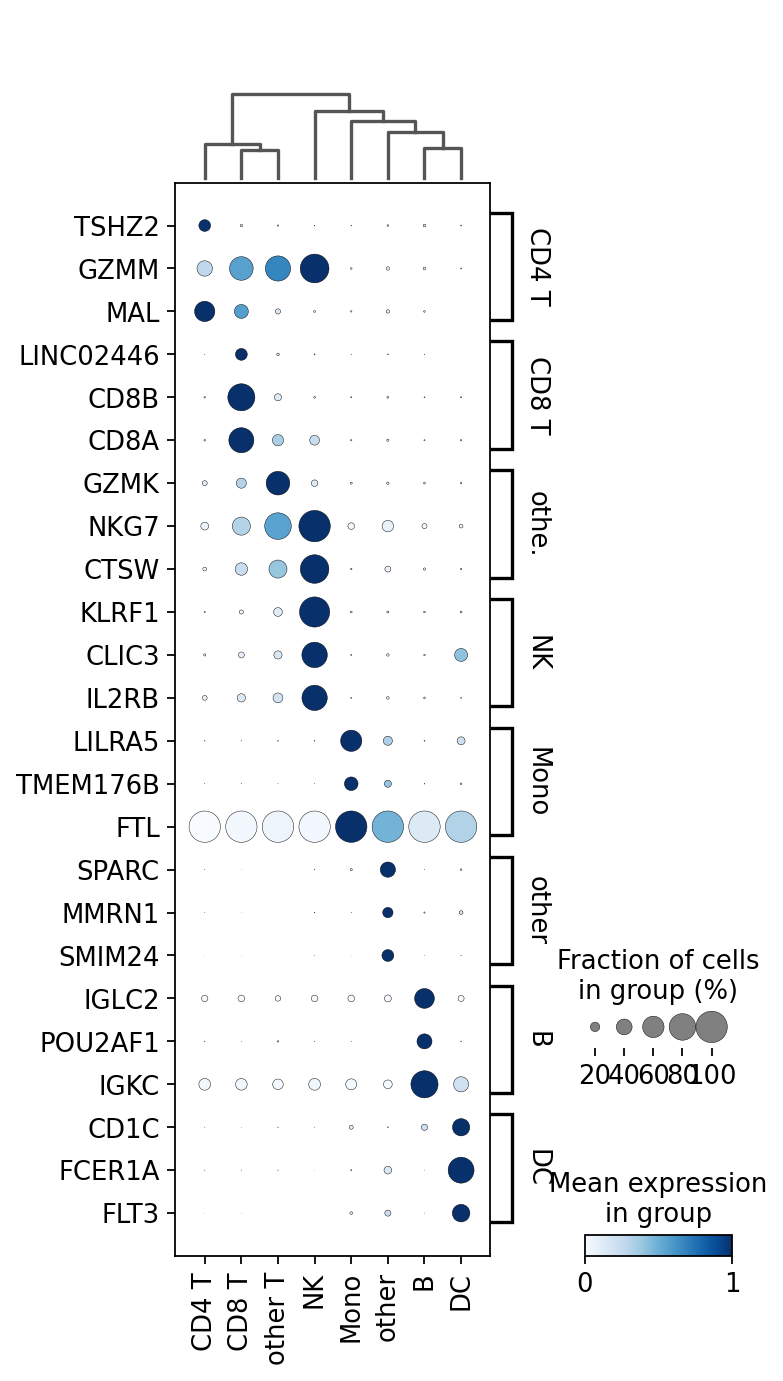

In [ ]:
sc.pl.dotplot(
    adata,
    markers,
    groupby='celltype.l1',
    dendrogram=True,
    color_map="Blues",
    swap_axes=True,
    use_raw=True,
    standard_scale="var",
)

## Домашнее задание

Изучите документацию scVI: https://docs.scvi-tools.org/en/stable/api/reference/scvi.model.SCVI.html.

Какие параметры модели можно регулировать? За что они отвечают? Попробуйте поменять их значения и исследуйте, как они влияют на качество коррекции батч-эффекта на использованном нами датасете.

Какие параметры сильно влияют на обучение? Какие дают наилучший результат?

In [ ]:
#ваш код